In [2]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss, Conv2d, MaxPool2d, LayerNorm, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import math
from torchmetrics import ScaleInvariantSignalNoiseRatio
import pickle

/home/dfedorovsky/anaconda3/envs/beamformer/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
from DataLoader import DataLoaderAll

X,Y_mask,speech,mix1,X_complex = DataLoaderAll.data_loader(n_noise=100)

# MaskNet + Training

In [4]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:
# MASK NET
SAMPLE_RATE = 16000
INPUT_CHANNEL = 4 # Always two -> Real and Imaginary part 
D_TF = 1024#1024

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()

        self.pe = PositionalEncoding(d_model=196)
        self.ln11 = LayerNorm(normalized_shape=(196))
        self.ln12 = LayerNorm(normalized_shape=(196))
        self.mha1 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf1 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf12 = Linear(in_features=D_TF,out_features=196)

        self.pe2 = PositionalEncoding(d_model=196)
        self.ln21 = LayerNorm(normalized_shape=(196))
        self.ln22 = LayerNorm(normalized_shape=(196))
        self.mha2 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf2 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf22 = Linear(in_features=D_TF,out_features=196)

        self.fc = Linear(in_features=4,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        
        x = x.reshape(INPUT_CHANNEL,513,196)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = F.relu(z)
        z = self.lintf12(z)
        x = z+z_2+x

        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = F.relu(z)
        z = self.lintf22(z)
        x = z+z_2+x
        
        x = x.view(513,196,4)

        x = self.fc(x)
        speech_pred = self.sigmoid(x)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 4))))

---------------------------------------------------------------------------------------
           Layer (type)                   Output Shape         Param #     Tr. Param #
   PositionalEncoding-1                  [4, 513, 196]               0               0
            LayerNorm-2                  [4, 513, 196]             392             392
   MultiheadAttention-3     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-4                  [4, 513, 196]             392             392
               Linear-5                 [4, 513, 1024]         201,728         201,728
               Linear-6                  [4, 513, 196]         200,900         200,900
            LayerNorm-7                  [4, 513, 196]             392             392
   MultiheadAttention-8     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-9                  [4, 513, 196]             392             392
              Linear-10                 [4

In [10]:
EPOCHS = 100
LEN_TRAIN = 2000
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.0001#0.0001
BATCH_SIZE = 1#64
LEARN_LOSS_PARAMS = False
device =  torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[3])

#lossBCE = BCELoss()
lossSiSNR = ScaleInvariantSignalNoiseRatio().to(device)

opt = Adam(model.parameters(), lr=INIT_LR)
lambda1 = lambda epoch: 0.65 ** epoch
#lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=opt, lr_lambda=lambda1)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(X)-LEN_TRAIN)+LEN_TRAIN)
    model.eval()
    pred = maskToWave(model(X[example_nr]),example_nr)
    val_loss = lossSiSNR(pred,Y[example_nr][0])
    model.train()
    return val_loss

istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256).to(device)
def maskToWave(speech_pred,i):
        #speech_pred = (speech_pred>0.2).float()
        noise_pred = torch.ones([513,speech_pred.shape[1]]).to(device)-speech_pred
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(X_complex[i], speech_pred)
        psd_noise = psd_transform(X_complex[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(X_complex[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)


print("[INFO] training the network...")
#X = stft_mix[:50].to(device)
#Y = Y.to(device)
X = X.to(device)
Y = speech.to(device)
X_complex = X_complex.to(device)
trainX = X[:LEN_TRAIN]
trainY = Y

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        y_s = trainY[i][0] # 0 speech only
        x = trainX[i]
        try:
            speech_pred=maskToWave(model(x),i)
        except Exception:
            continue
        try:
            loss = -lossSiSNR(speech_pred,y_s)
            # zero out the gradients, perform the backpropagation step, and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            H["train_loss"].append(float(loss))
        except Exception:
            continue
        if i % 10 == 0:
            val_loss = check_accuracy_validation(model)
            #H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    # Print results of Epoch        
    #print("Average Training Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Average Training Loss in Epoch",str(epoch+1),":",(-sum(H["train_loss"][-2000:]))/2000)
    #print("Average Validation Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    print("Total Validation Loss in Epoch",str(epoch+1),":",(sum(H["val_loss"][-10:]))/10)
    # Save Model after Epoch        
    MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TFall'
    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch" + str(epoch+1) + ".pt")
    print(totalTrainLoss)
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'
torch.save(model.state_dict(), MODEL_SAVE_PATH + "final" + ".pt")
with open(PICKLE_SAVE_PATH, 'wb') as f:
    pickle.dump(H, f)

/home/dfedorovsky/anaconda3/envs/beamformer/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ScaleInvariantSignalNoiseRatio). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


[INFO] training the network...
Epoch: 1/100


100%|██████████| 2000/2000 [00:33<00:00, 60.22it/s]


Average Training Loss in Epoch 1 : 0.7857393610384316
Total Validation Loss in Epoch 1 : 2.2718957126140595
0
Epoch: 2/100


100%|██████████| 2000/2000 [00:32<00:00, 61.87it/s]


Average Training Loss in Epoch 2 : 1.2698482548703904
Total Validation Loss in Epoch 2 : 2.8402023017406464
0
Epoch: 3/100


100%|██████████| 2000/2000 [00:32<00:00, 60.92it/s]


Average Training Loss in Epoch 3 : 1.7675975931310095
Total Validation Loss in Epoch 3 : 1.6163235768675803
0
Epoch: 4/100


100%|██████████| 2000/2000 [00:34<00:00, 58.75it/s]


Average Training Loss in Epoch 4 : 2.4629184586515183
Total Validation Loss in Epoch 4 : 3.155985748767853
0
Epoch: 5/100


100%|██████████| 2000/2000 [00:32<00:00, 61.24it/s]


Average Training Loss in Epoch 5 : 2.879149901188126
Total Validation Loss in Epoch 5 : 1.9242789149284363
0
Epoch: 6/100


100%|██████████| 2000/2000 [00:35<00:00, 56.99it/s]


Average Training Loss in Epoch 6 : 3.316169837573063
Total Validation Loss in Epoch 6 : 3.4161229610443113
0
Epoch: 7/100


100%|██████████| 2000/2000 [00:34<00:00, 57.32it/s]


Average Training Loss in Epoch 7 : 3.731171283540898
Total Validation Loss in Epoch 7 : 5.048330867290497
0
Epoch: 8/100


100%|██████████| 2000/2000 [00:32<00:00, 61.06it/s]


Average Training Loss in Epoch 8 : 3.921861916114576
Total Validation Loss in Epoch 8 : 2.3924390077590942
0
Epoch: 9/100


100%|██████████| 2000/2000 [00:33<00:00, 59.43it/s]


Average Training Loss in Epoch 9 : 3.584159147015307
Total Validation Loss in Epoch 9 : 7.099445915222168
0
Epoch: 10/100


100%|██████████| 2000/2000 [00:34<00:00, 57.73it/s]


Average Training Loss in Epoch 10 : 4.019801840008702
Total Validation Loss in Epoch 10 : 3.302844685316086
0
Epoch: 11/100


100%|██████████| 2000/2000 [00:34<00:00, 57.60it/s]


Average Training Loss in Epoch 11 : 4.520712224135932
Total Validation Loss in Epoch 11 : 8.601692988350987
0
Epoch: 12/100


100%|██████████| 2000/2000 [00:33<00:00, 59.54it/s]


Average Training Loss in Epoch 12 : 4.260668016878888
Total Validation Loss in Epoch 12 : 1.5375338315963745
0
Epoch: 13/100


100%|██████████| 2000/2000 [00:32<00:00, 61.72it/s]


Average Training Loss in Epoch 13 : 4.553042861701921
Total Validation Loss in Epoch 13 : 3.0002325773239136
0
Epoch: 14/100


100%|██████████| 2000/2000 [00:32<00:00, 62.26it/s]


Average Training Loss in Epoch 14 : 4.8375725620316805
Total Validation Loss in Epoch 14 : 7.401397180557251
0
Epoch: 15/100


100%|██████████| 2000/2000 [00:33<00:00, 59.90it/s]


Average Training Loss in Epoch 15 : 5.166690212825779
Total Validation Loss in Epoch 15 : 2.1895316362380983
0
Epoch: 16/100


100%|██████████| 2000/2000 [00:33<00:00, 59.06it/s]


Average Training Loss in Epoch 16 : 4.4645830528475345
Total Validation Loss in Epoch 16 : 4.041794141754508
0
Epoch: 17/100


100%|██████████| 2000/2000 [00:33<00:00, 60.02it/s]


Average Training Loss in Epoch 17 : 5.04523831537785
Total Validation Loss in Epoch 17 : 6.270254448056221
0
Epoch: 18/100


100%|██████████| 2000/2000 [00:34<00:00, 58.49it/s]


Average Training Loss in Epoch 18 : 5.281455823520664
Total Validation Loss in Epoch 18 : 3.8326195307075976
0
Epoch: 19/100


100%|██████████| 2000/2000 [00:33<00:00, 59.23it/s]


Average Training Loss in Epoch 19 : 5.419602782357484
Total Validation Loss in Epoch 19 : 5.865248066186905
0
Epoch: 20/100


100%|██████████| 2000/2000 [00:31<00:00, 62.63it/s]


Average Training Loss in Epoch 20 : 5.638963273984147
Total Validation Loss in Epoch 20 : 7.799265837669372
0
Epoch: 21/100


100%|██████████| 2000/2000 [00:33<00:00, 59.77it/s]


Average Training Loss in Epoch 21 : 4.864383471017703
Total Validation Loss in Epoch 21 : 6.02901109457016
0
Epoch: 22/100


100%|██████████| 2000/2000 [00:33<00:00, 59.04it/s]


Average Training Loss in Epoch 22 : 4.946181467339862
Total Validation Loss in Epoch 22 : 4.569690153002739
0
Epoch: 23/100


100%|██████████| 2000/2000 [00:35<00:00, 56.82it/s]


Average Training Loss in Epoch 23 : 4.5965787269352
Total Validation Loss in Epoch 23 : 7.82450088262558
0
Epoch: 24/100


100%|██████████| 2000/2000 [00:33<00:00, 59.26it/s]


Average Training Loss in Epoch 24 : 5.233775342490058
Total Validation Loss in Epoch 24 : 6.85005476474762
0
Epoch: 25/100


100%|██████████| 2000/2000 [00:35<00:00, 55.58it/s]


Average Training Loss in Epoch 25 : 4.963838529791243
Total Validation Loss in Epoch 25 : 7.216120100021362
0
Epoch: 26/100


100%|██████████| 2000/2000 [00:34<00:00, 58.81it/s]


Average Training Loss in Epoch 26 : 5.58498846583115
Total Validation Loss in Epoch 26 : 8.691330063343049
0
Epoch: 27/100


100%|██████████| 2000/2000 [00:33<00:00, 58.91it/s]


Average Training Loss in Epoch 27 : 5.499956252883188
Total Validation Loss in Epoch 27 : 1.6978962123394012
0
Epoch: 28/100


100%|██████████| 2000/2000 [00:35<00:00, 57.12it/s]


Average Training Loss in Epoch 28 : 5.588547539929859
Total Validation Loss in Epoch 28 : 7.342556452751159
0
Epoch: 29/100


100%|██████████| 2000/2000 [00:35<00:00, 56.41it/s]


Average Training Loss in Epoch 29 : 5.613226922495058
Total Validation Loss in Epoch 29 : 3.97103950381279
0
Epoch: 30/100


100%|██████████| 2000/2000 [00:33<00:00, 59.05it/s]


Average Training Loss in Epoch 30 : 5.26797355970554
Total Validation Loss in Epoch 30 : 9.141066801548003
0
Epoch: 31/100


100%|██████████| 2000/2000 [00:33<00:00, 60.52it/s]


Average Training Loss in Epoch 31 : 6.1278490524897355
Total Validation Loss in Epoch 31 : 5.8385877221822735
0
Epoch: 32/100


100%|██████████| 2000/2000 [00:34<00:00, 57.17it/s]


Average Training Loss in Epoch 32 : 5.900671539265662
Total Validation Loss in Epoch 32 : 7.5262951254844666
0
Epoch: 33/100


100%|██████████| 2000/2000 [00:33<00:00, 60.27it/s]


Average Training Loss in Epoch 33 : 5.876399207795039
Total Validation Loss in Epoch 33 : 6.867916989326477
0
Epoch: 34/100


100%|██████████| 2000/2000 [00:33<00:00, 60.16it/s]


Average Training Loss in Epoch 34 : 6.483943164504598
Total Validation Loss in Epoch 34 : 7.329887044429779
0
Epoch: 35/100


100%|██████████| 2000/2000 [00:33<00:00, 59.77it/s]


Average Training Loss in Epoch 35 : 6.6128747147601095
Total Validation Loss in Epoch 35 : 8.622773122787475
0
Epoch: 36/100


100%|██████████| 2000/2000 [00:35<00:00, 56.74it/s]


Average Training Loss in Epoch 36 : 6.45481454147771
Total Validation Loss in Epoch 36 : 5.9568421125411986
0
Epoch: 37/100


100%|██████████| 2000/2000 [00:34<00:00, 57.87it/s]


Average Training Loss in Epoch 37 : 6.634877652476542
Total Validation Loss in Epoch 37 : 8.761619997024535
0
Epoch: 38/100


100%|██████████| 2000/2000 [00:34<00:00, 58.16it/s]


Average Training Loss in Epoch 38 : 6.7681396298911425
Total Validation Loss in Epoch 38 : 2.5962726712226867
0
Epoch: 39/100


100%|██████████| 2000/2000 [00:34<00:00, 57.16it/s]


Average Training Loss in Epoch 39 : 4.852250651242677
Total Validation Loss in Epoch 39 : 4.96010788679123
0
Epoch: 40/100


100%|██████████| 2000/2000 [00:34<00:00, 57.46it/s]


Average Training Loss in Epoch 40 : 6.751804574100941
Total Validation Loss in Epoch 40 : 5.479342037439347
0
Epoch: 41/100


100%|██████████| 2000/2000 [00:33<00:00, 59.36it/s]


Average Training Loss in Epoch 41 : 7.09492656403291
Total Validation Loss in Epoch 41 : 6.524583441019058
0
Epoch: 42/100


100%|██████████| 2000/2000 [00:33<00:00, 60.21it/s]


Average Training Loss in Epoch 42 : 7.403355442085769
Total Validation Loss in Epoch 42 : 6.970249590277672
0
Epoch: 43/100


100%|██████████| 2000/2000 [00:34<00:00, 58.79it/s]


Average Training Loss in Epoch 43 : 7.416719612840563
Total Validation Loss in Epoch 43 : 11.613452672958374
0
Epoch: 44/100


100%|██████████| 2000/2000 [00:33<00:00, 59.49it/s]


Average Training Loss in Epoch 44 : 7.327500909350812
Total Validation Loss in Epoch 44 : 8.810090732574462
0
Epoch: 45/100


100%|██████████| 2000/2000 [00:33<00:00, 59.04it/s]


Average Training Loss in Epoch 45 : 7.7085768622923645
Total Validation Loss in Epoch 45 : 7.473319959640503
0
Epoch: 46/100


100%|██████████| 2000/2000 [00:33<00:00, 59.36it/s]


Average Training Loss in Epoch 46 : 7.843254071510397
Total Validation Loss in Epoch 46 : 8.171651530265809
0
Epoch: 47/100


100%|██████████| 2000/2000 [00:31<00:00, 62.77it/s]


Average Training Loss in Epoch 47 : 7.623603357739746
Total Validation Loss in Epoch 47 : 7.706465005874634
0
Epoch: 48/100


100%|██████████| 2000/2000 [00:34<00:00, 57.75it/s]


Average Training Loss in Epoch 48 : 8.123023582478403
Total Validation Loss in Epoch 48 : 2.9144257068634034
0
Epoch: 49/100


100%|██████████| 2000/2000 [00:33<00:00, 59.44it/s]


Average Training Loss in Epoch 49 : 8.072199265622244
Total Validation Loss in Epoch 49 : 8.02601710446179
0
Epoch: 50/100


100%|██████████| 2000/2000 [00:33<00:00, 59.03it/s]


Average Training Loss in Epoch 50 : 7.966369083836675
Total Validation Loss in Epoch 50 : 9.73108685016632
0
Epoch: 51/100


100%|██████████| 2000/2000 [00:33<00:00, 59.84it/s]


Average Training Loss in Epoch 51 : 8.002666833798866
Total Validation Loss in Epoch 51 : 6.406892454624176
0
Epoch: 52/100


100%|██████████| 2000/2000 [00:33<00:00, 59.35it/s]


Average Training Loss in Epoch 52 : 8.29615359986294
Total Validation Loss in Epoch 52 : 6.01984429359436
0
Epoch: 53/100


100%|██████████| 2000/2000 [00:33<00:00, 60.50it/s]


Average Training Loss in Epoch 53 : 8.297331054023699
Total Validation Loss in Epoch 53 : 4.253023497015238
0
Epoch: 54/100


100%|██████████| 2000/2000 [00:34<00:00, 58.52it/s]


Average Training Loss in Epoch 54 : 8.564087026866385
Total Validation Loss in Epoch 54 : 9.418537187576295
0
Epoch: 55/100


100%|██████████| 2000/2000 [00:32<00:00, 60.93it/s]


Average Training Loss in Epoch 55 : 8.509645566904451
Total Validation Loss in Epoch 55 : 10.149158501625061
0
Epoch: 56/100


100%|██████████| 2000/2000 [00:33<00:00, 60.00it/s]


Average Training Loss in Epoch 56 : 7.77486483372678
Total Validation Loss in Epoch 56 : 9.713460636138915
0
Epoch: 57/100


100%|██████████| 2000/2000 [00:33<00:00, 59.11it/s]


Average Training Loss in Epoch 57 : 8.770600651097949
Total Validation Loss in Epoch 57 : 7.438054101914167
0
Epoch: 58/100


100%|██████████| 2000/2000 [00:33<00:00, 59.29it/s]


Average Training Loss in Epoch 58 : 8.782534685526626
Total Validation Loss in Epoch 58 : 2.20897262096405
0
Epoch: 59/100


100%|██████████| 2000/2000 [00:35<00:00, 56.73it/s]


Average Training Loss in Epoch 59 : 8.895739065165632
Total Validation Loss in Epoch 59 : 8.512424659729003
0
Epoch: 60/100


100%|██████████| 2000/2000 [00:35<00:00, 56.83it/s]


Average Training Loss in Epoch 60 : 8.417302981678397
Total Validation Loss in Epoch 60 : 9.86786048412323
0
Epoch: 61/100


100%|██████████| 2000/2000 [00:34<00:00, 57.45it/s]


Average Training Loss in Epoch 61 : 9.05540094393026
Total Validation Loss in Epoch 61 : 8.387591099739074
0
Epoch: 62/100


100%|██████████| 2000/2000 [00:35<00:00, 56.35it/s]


Average Training Loss in Epoch 62 : 8.987282806946197
Total Validation Loss in Epoch 62 : 10.731864881515502
0
Epoch: 63/100


100%|██████████| 2000/2000 [00:33<00:00, 59.84it/s]


Average Training Loss in Epoch 63 : 9.088860212428495
Total Validation Loss in Epoch 63 : 11.142126178741455
0
Epoch: 64/100


100%|██████████| 2000/2000 [00:32<00:00, 60.94it/s]


Average Training Loss in Epoch 64 : 9.24137814443698
Total Validation Loss in Epoch 64 : 5.064655733108521
0
Epoch: 65/100


100%|██████████| 2000/2000 [00:34<00:00, 58.56it/s]


Average Training Loss in Epoch 65 : 9.223741422269493
Total Validation Loss in Epoch 65 : 8.865287637710571
0
Epoch: 66/100


100%|██████████| 2000/2000 [00:33<00:00, 60.11it/s]


Average Training Loss in Epoch 66 : 9.194622917592175
Total Validation Loss in Epoch 66 : 7.246748518943787
0
Epoch: 67/100


100%|██████████| 2000/2000 [00:33<00:00, 59.60it/s]


Average Training Loss in Epoch 67 : 8.74885898310307
Total Validation Loss in Epoch 67 : 10.028776550292969
0
Epoch: 68/100


100%|██████████| 2000/2000 [00:33<00:00, 59.46it/s]


Average Training Loss in Epoch 68 : 9.374361484187656
Total Validation Loss in Epoch 68 : 7.9412676900625225
0
Epoch: 69/100


100%|██████████| 2000/2000 [00:33<00:00, 60.31it/s]


Average Training Loss in Epoch 69 : 9.437175833660062
Total Validation Loss in Epoch 69 : 4.086843720078468
0
Epoch: 70/100


100%|██████████| 2000/2000 [00:33<00:00, 59.63it/s]


Average Training Loss in Epoch 70 : 9.540161636006554
Total Validation Loss in Epoch 70 : 11.1863232254982
0
Epoch: 71/100


100%|██████████| 2000/2000 [00:34<00:00, 57.69it/s]


Average Training Loss in Epoch 71 : 9.628034411173779
Total Validation Loss in Epoch 71 : 10.828449261188506
0
Epoch: 72/100


100%|██████████| 2000/2000 [00:34<00:00, 58.73it/s]


Average Training Loss in Epoch 72 : 9.636409466068843
Total Validation Loss in Epoch 72 : 6.272598078846931
0
Epoch: 73/100


100%|██████████| 2000/2000 [00:32<00:00, 61.12it/s]


Average Training Loss in Epoch 73 : 9.561621338424505
Total Validation Loss in Epoch 73 : 7.666555762290955
0
Epoch: 74/100


100%|██████████| 2000/2000 [00:33<00:00, 59.81it/s]


Average Training Loss in Epoch 74 : 9.744335229266087
Total Validation Loss in Epoch 74 : 12.841111755371093
0
Epoch: 75/100


100%|██████████| 2000/2000 [00:34<00:00, 58.79it/s]


Average Training Loss in Epoch 75 : 9.798182440007105
Total Validation Loss in Epoch 75 : 8.504199063777923
0
Epoch: 76/100


100%|██████████| 2000/2000 [00:34<00:00, 57.74it/s]


Average Training Loss in Epoch 76 : 9.79902790401876
Total Validation Loss in Epoch 76 : 6.883256733417511
0
Epoch: 77/100


100%|██████████| 2000/2000 [00:34<00:00, 57.56it/s]


Average Training Loss in Epoch 77 : 9.953873188452794
Total Validation Loss in Epoch 77 : 5.786066055297852
0
Epoch: 78/100


100%|██████████| 2000/2000 [00:35<00:00, 56.63it/s]


Average Training Loss in Epoch 78 : 9.95742519622267
Total Validation Loss in Epoch 78 : 12.841485071182252
0
Epoch: 79/100


100%|██████████| 2000/2000 [00:33<00:00, 59.77it/s]


Average Training Loss in Epoch 79 : 9.850604360300116
Total Validation Loss in Epoch 79 : 11.095275402069092
0
Epoch: 80/100


100%|██████████| 2000/2000 [00:32<00:00, 61.53it/s]


Average Training Loss in Epoch 80 : 9.751919285435113
Total Validation Loss in Epoch 80 : 7.920574712753296
0
Epoch: 81/100


100%|██████████| 2000/2000 [00:32<00:00, 60.75it/s]


Average Training Loss in Epoch 81 : 9.958828382123727
Total Validation Loss in Epoch 81 : 9.344005134701728
0
Epoch: 82/100


100%|██████████| 2000/2000 [00:34<00:00, 57.93it/s]


Average Training Loss in Epoch 82 : 9.908571027934551
Total Validation Loss in Epoch 82 : 9.375715494155884
0
Epoch: 83/100


100%|██████████| 2000/2000 [00:36<00:00, 54.83it/s]


Average Training Loss in Epoch 83 : 7.365263970257715
Total Validation Loss in Epoch 83 : 6.267049714922905
0
Epoch: 84/100


100%|██████████| 2000/2000 [00:33<00:00, 59.11it/s]


Average Training Loss in Epoch 84 : 9.826225014471216
Total Validation Loss in Epoch 84 : 9.002984917163849
0
Epoch: 85/100


100%|██████████| 2000/2000 [00:33<00:00, 58.85it/s]


Average Training Loss in Epoch 85 : 10.094812024866231
Total Validation Loss in Epoch 85 : 11.826831579208374
0
Epoch: 86/100


100%|██████████| 2000/2000 [00:33<00:00, 58.83it/s]


Average Training Loss in Epoch 86 : 10.163161582184955
Total Validation Loss in Epoch 86 : 8.313956171274185
0
Epoch: 87/100


100%|██████████| 2000/2000 [00:32<00:00, 61.45it/s]


Average Training Loss in Epoch 87 : 10.235999675666914
Total Validation Loss in Epoch 87 : 9.465381354093552
0
Epoch: 88/100


100%|██████████| 2000/2000 [00:33<00:00, 59.69it/s]


Average Training Loss in Epoch 88 : 10.023714277800172
Total Validation Loss in Epoch 88 : 9.402114614844322
0
Epoch: 89/100


100%|██████████| 2000/2000 [00:34<00:00, 58.70it/s]


Average Training Loss in Epoch 89 : 9.97057563954452
Total Validation Loss in Epoch 89 : 8.591421711444855
0
Epoch: 90/100


100%|██████████| 2000/2000 [00:34<00:00, 58.64it/s]


Average Training Loss in Epoch 90 : 9.919413410372567
Total Validation Loss in Epoch 90 : 8.260297882556916
0
Epoch: 91/100


100%|██████████| 2000/2000 [00:31<00:00, 63.90it/s]


Average Training Loss in Epoch 91 : 10.343913943231687
Total Validation Loss in Epoch 91 : 11.411947631835938
0
Epoch: 92/100


100%|██████████| 2000/2000 [00:34<00:00, 58.69it/s]


Average Training Loss in Epoch 92 : 10.35877291629091
Total Validation Loss in Epoch 92 : 8.028985786437989
0
Epoch: 93/100


100%|██████████| 2000/2000 [00:33<00:00, 59.01it/s]


Average Training Loss in Epoch 93 : 10.488188889351674
Total Validation Loss in Epoch 93 : 15.349675559997559
0
Epoch: 94/100


100%|██████████| 2000/2000 [00:31<00:00, 62.69it/s]


Average Training Loss in Epoch 94 : 10.35149494141247
Total Validation Loss in Epoch 94 : 11.44174349308014
0
Epoch: 95/100


100%|██████████| 2000/2000 [00:35<00:00, 56.31it/s]


Average Training Loss in Epoch 95 : 10.468838385533308
Total Validation Loss in Epoch 95 : 13.529879283905029
0
Epoch: 96/100


100%|██████████| 2000/2000 [00:34<00:00, 57.83it/s]


Average Training Loss in Epoch 96 : 10.412978927241639
Total Validation Loss in Epoch 96 : 8.574351716041566
0
Epoch: 97/100


100%|██████████| 2000/2000 [00:35<00:00, 56.01it/s]


Average Training Loss in Epoch 97 : 10.282279933549464
Total Validation Loss in Epoch 97 : 11.600073647499084
0
Epoch: 98/100


100%|██████████| 2000/2000 [00:33<00:00, 59.69it/s]


Average Training Loss in Epoch 98 : 10.512391176309437
Total Validation Loss in Epoch 98 : 11.744762396812439
0
Epoch: 99/100


100%|██████████| 2000/2000 [00:34<00:00, 57.70it/s]


Average Training Loss in Epoch 99 : 10.43679190613469
Total Validation Loss in Epoch 99 : 8.669315940141678
0
Epoch: 100/100


100%|██████████| 2000/2000 [00:34<00:00, 57.50it/s]


Average Training Loss in Epoch 100 : 10.611896385782165
Total Validation Loss in Epoch 100 : 6.594376587867737
0


## Load Model & Evaluate

In [6]:
PATH = MODEL_SAVE_PATH = "/project/data_asr/CHiME5/data/librenoise/models/TFallepoch100.pt"
#device = torch.device('cuda:0')
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = MaskNet()
model.load_state_dict(new_state_dict)
#model= torch.nn.DataParallel(model)
#model.load_state_dict(torch.load(PATH))#,map_location=device))
#model.to(device)
model.eval()

MaskNet(
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf1): Linear(in_features=196, out_features=1024, bias=True)
  (lintf12): Linear(in_features=1024, out_features=196, bias=True)
  (pe2): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln21): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf2): Linear(in_features=196, out_features=1024, bias=True)
  (lintf22): Linear(in_features=1024, out_features=196, bias=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
 

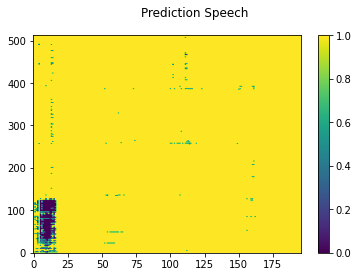

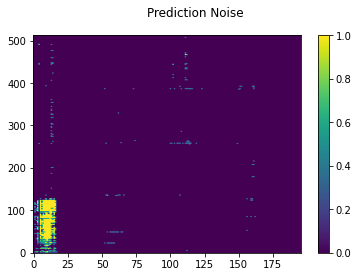

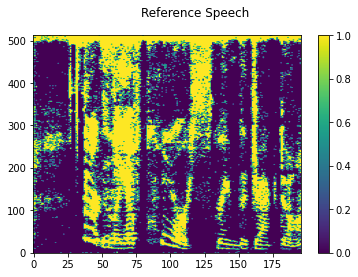

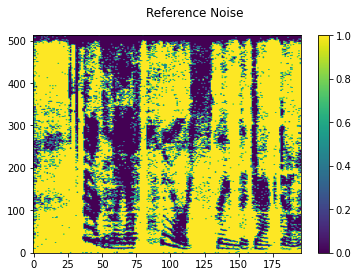

In [8]:
X = X.cpu()
Y = Y_mask.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])>0.15).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y_mask[e_nr][0], title="Reference Speech")
    plot_mask(Y_mask[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(260)

In [9]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)
X_complex = X_complex.cpu()

def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()

def evaluateSiSNR(wave, i):
    score = si_snr(wave, speech[i])
    #print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def maskToWave(speech_pred,i):
        #speech_pred = (speech_pred>0.2).float()
        noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(X_complex[i], speech_pred)
        psd_noise = psd_transform(X_complex[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(X_complex[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/model_out.wav",wave.reshape(1,-1),16000)

index = 2013
speech_pred = (model(X[index])>0.2).float()
#noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,index)#noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
print(wave.shape)
print(wave)
save_sample(index, wave=wave)
score = evaluateSiSNR(wave,index)#Should be ~28
print(f"Si-SNR score: {score}")

torch.Size([50000])
tensor([0.0259, 0.0265, 0.0251,  ..., 0.0399, 0.0367, 0.0335])
Si-SNR score: 6.385181427001953


In [10]:
# Test Set
scores = []
for index in range(2000,2703):
    speech_pred = (model(X[index])>0.2).float()
    wave = maskToWave(speech_pred,index)#X hat nicht mehr nur 2, sondern 4 channel
    scores.append(si_snr(wave, speech[index])-si_snr(mix1[index],speech[index]))

np.mean(scores)

# Average improvement with 100 noises: 3.3867 (30 epochs)

3.386744122077866